In [132]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier

from sklearn.linear_model import PassiveAggressiveClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC

from torchsummary import summary

import pytorch_lightning as pl

# Attributes Description

- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD)
- High - Highest price reached in the day
- Low  - Lowest price reached in the day
- Close - price of the stock at market close
- Volume - Number of shares traded.Volume can indicate market strength, as rising markets on increasing volume are typically viewed as strong and healthy
- Name - the stock's ticker name
- Target - 0 if close price of the next day is higher / 1 if lower

# EDA

In [6]:
df = pd.read_csv("all_stocks_5yr.csv")
df['Target'] = (df['close'].shift(-1) > df['close']).astype(int)
df

,date,open,high,low,close,volume,Name,Target
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,1
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,1
...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,0
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,0
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,0
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
 7   Target  619040 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 37.8+ MB


In [8]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
Target     0
dtype: int64

In [9]:
df.dropna(inplace = True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.nunique()

date        1259
open       49715
high       81499
low        82354
close      51151
volume    586434
Name         505
Target         2
dtype: int64

In [12]:
# Divide date into month, year, day of week
df = df.astype({'date':'datetime64[ns]'})
df['Day'] = df['date'].dt.day_name()
df['Month'] = df['date'].dt.month
df['Year'] = df['date'].dt.year
df

,date,open,high,low,close,volume,Name,Target,Day,Month,Year
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0,Friday,2,2013
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0,Monday,2,2013
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,1,Tuesday,2,2013
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0,Wednesday,2,2013
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,1,Thursday,2,2013
...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,0,Thursday,2,2018
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,0,Friday,2,2018
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,0,Monday,2,2018
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,1,Tuesday,2,2018


#### Top 10 company have highest average volume

In [13]:
mean_dict = {}

for key in df['Name'].unique():
    value = df[df['Name'] == key]['volume'].mean()
    mean_dict[key]= value

In [97]:
average_vol = pd.Series(mean_dict)
top10 = average_vol.sort_values(ascending=False)[:10]

comp_list = []
for comp in top10.index:
    comp_list.append(comp)

comp_list

['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']

- 'BAC' : Bank of America Corp
- 'AAPL': Apple
- 'GE'  : General Electric
- 'F'   : Ford
- 'FB'  : Meta
- 'MSFT': Microsoft
- 'AMD' : Advanced Micro Devices
- 'MU'  : Micron Technology Inc
- 'INTC': Intel
- 'CSCO': Cisco

In [98]:
def subdataframe(comp_list):
    new_df = df[df['Name'].isin(comp_list)]
    return new_df

comp_df = subdataframe(comp_list)

#### Visualization

In [16]:
from functools import partial

def company(name, start_date, end_date):
    # Choosing company and time range
    f = partial(pd.to_datetime, dayfirst=True)
    mask = df['date'].between(f(start_date), f(end_date))
    comp = df.loc[(df.Name == name) & mask]
    comp_df = comp.copy()
    # ---------------------------------------------------------------------------------------------
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    f, (ax4) = plt.subplots(1, figsize=(14,5))
    f, (ax3) = plt.subplots(1, figsize=(14,5))

    # ---------Plotting closing vs opening price --------------------------------------------------
    ax1.plot(comp_df["date"], comp_df["open"], color='blue', label = 'open price')
    ax1.plot(comp_df["date"], comp_df["close"], color='brown', label = 'close price')

    ax1.set_xlabel("date", fontsize=12)
    ax1.set_ylabel("Stock Price")
    ax1.legend()
    ax1.set_title(f"{name} Open vs Close Price History")

    # ----------Plotting high vs low price---------------------------------------------------------
    ax2.plot(comp_df["date"], comp_df["high"], color='red', label = 'high price')
    ax2.plot(comp_df["date"], comp_df["low"], color='green', label = 'low price')

    ax2.set_xlabel("date", fontsize=12)
    ax2.set_ylabel("Stock Price")
    ax2.legend()
    ax2.set_title(f"{name} High vs Low Price History")

    # ----------Plotting volume--------------------------------------------------------------------
    ax3.plot(comp_df["date"], comp_df["volume"], color="blue")
    ax3.set_xlabel("date", fontsize=12)
    ax3.set_ylabel("Volume")
    ax3.set_title(f"{name} Volume History")

    # ----------Plotting close between high and low------------------------------------------------
    ax4.plot(comp_df["date"], comp_df["close"], color='blue', label = 'close price')
    ax4.plot(comp_df["date"], comp_df["high"], color='red', label = 'high price')
    ax4.plot(comp_df["date"], comp_df["low"], color='green', label = 'low price')
    ax4.plot(comp_df["date"], comp_df["open"], color='black', label = 'low price')

    ax4.set_xlabel("date", fontsize=12)
    ax4.set_ylabel("Stock Price")
    ax4.legend()
    ax4.set_title(f"{name} Close Price History")

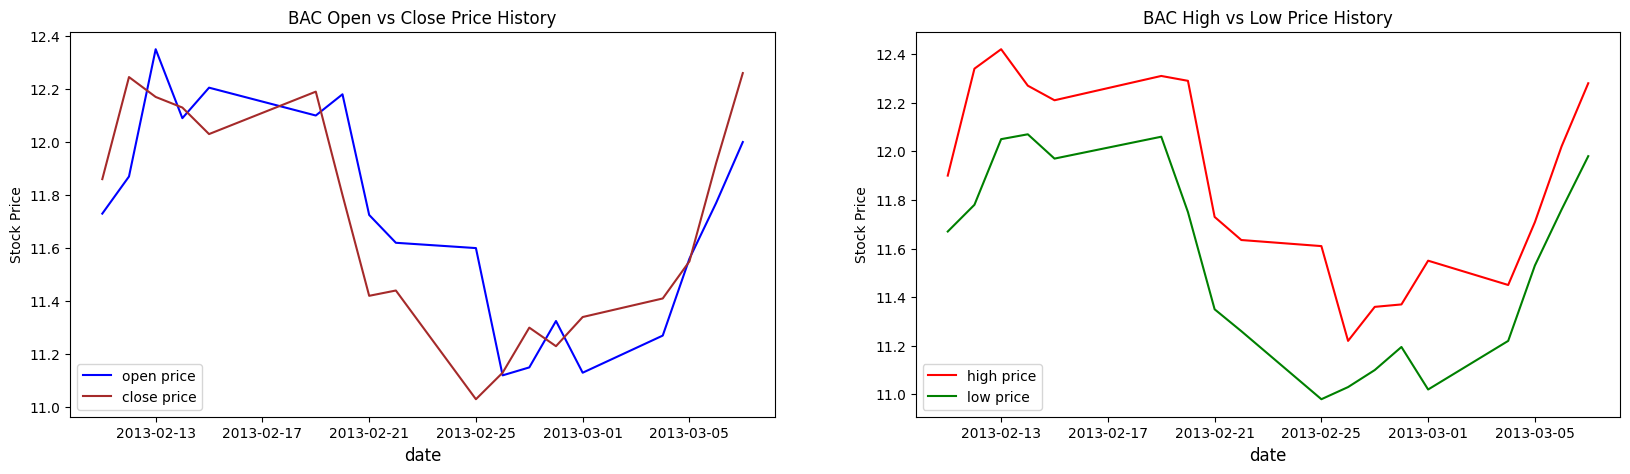

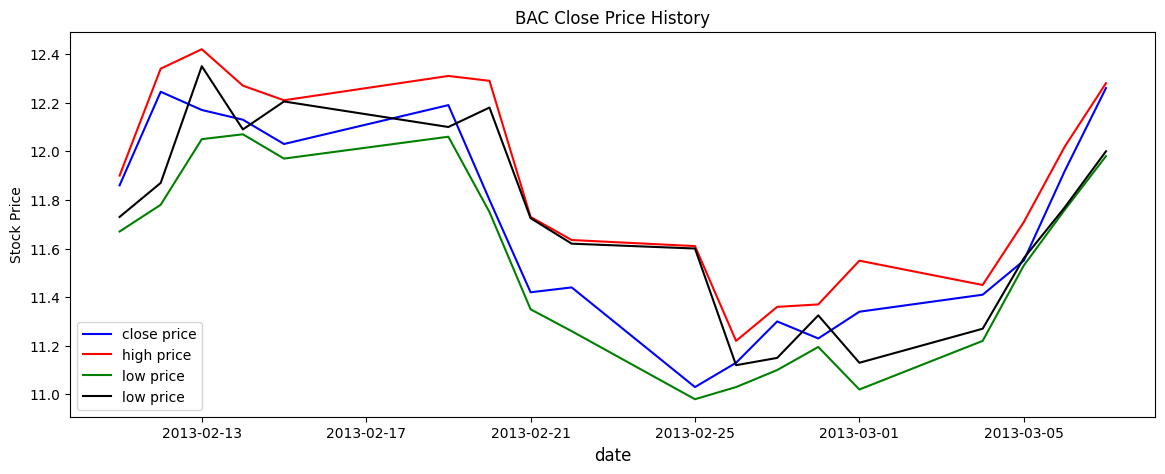

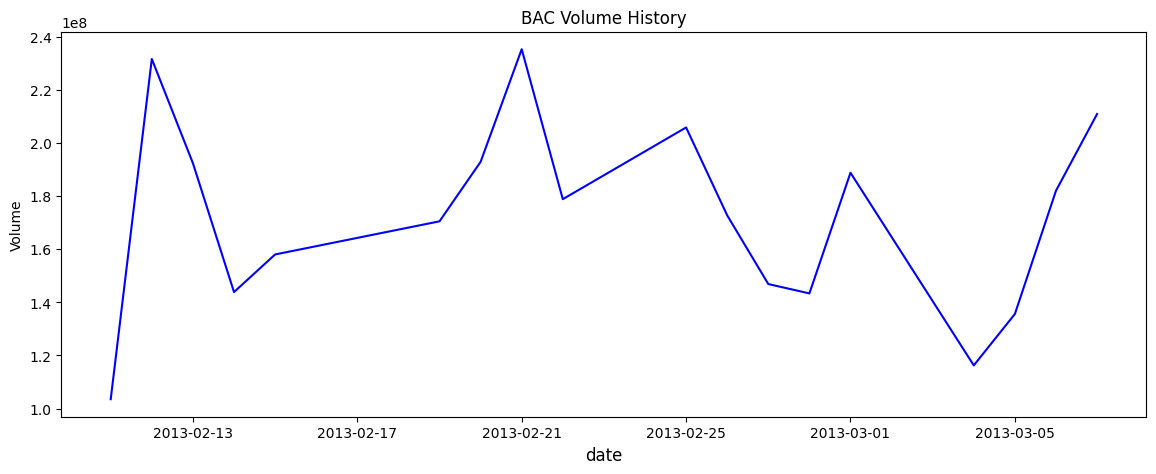

In [19]:
#Choose company and time range to plot
company('BAC', '2013-02-11', '2013-03-07')
# company('AAPL', '2014-03-11', '2014-05-20')
# company('BAC', '2013-02-11', '2018-02-07')

# Preprocess

#### Ranking features

In [88]:
ranking_df = comp_df.copy()

In [89]:
ranking_df.drop('date', axis = 1, inplace = True)
cate_cols = ranking_df[['Day', 'Month', 'Year', 'Name']]
#----------------Encoding-------------------------------------------------------------------
le = LabelEncoder()

for col in cate_cols:
    ranking_df[col] = le.fit_transform(ranking_df[col])
y = ranking_df['Target']
X = ranking_df.drop('Target', axis = 1)

#----------------Scaling--------------------------------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

#----------------Splitting------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

1    6454
0    6136
Name: Target, dtype: int64

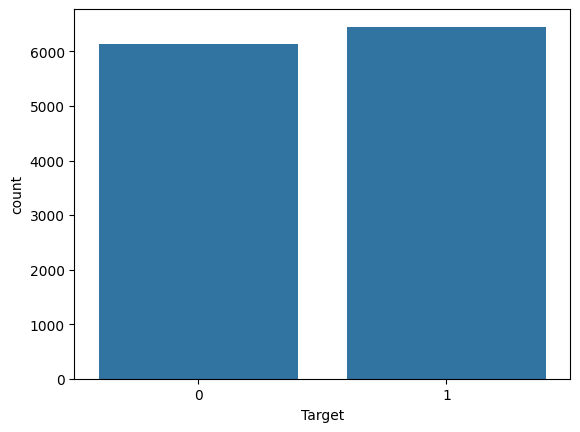

In [90]:
target = ranking_df['Target'].value_counts()
sns.countplot(x ='Target',  data = ranking_df)
target

- Target is balance

In [91]:
#----------------Finding the best parameter for Decision Tree--------------------------------
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10]
}

GS = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=6, verbose=3)

GS.fit(X_train, y_train)

preds_train = GS.predict(X_train)
acc = round(accuracy_score(y_train, preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

pred_test = GS.predict(X_test)
acc = round(accuracy_score(y_test, pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV 1/6] END .......criterion=gini, max_depth=2;, score=0.496 total time=   0.0s
[CV 2/6] END .......criterion=gini, max_depth=2;, score=0.522 total time=   0.0s
[CV 3/6] END .......criterion=gini, max_depth=2;, score=0.519 total time=   0.0s
[CV 4/6] END .......criterion=gini, max_depth=2;, score=0.521 total time=   0.0s
[CV 5/6] END .......criterion=gini, max_depth=2;, score=0.501 total time=   0.0s
[CV 6/6] END .......criterion=gini, max_depth=2;, score=0.520 total time=   0.0s
[CV 1/6] END .......criterion=gini, max_depth=4;, score=0.521 total time=   0.0s
[CV 2/6] END .......criterion=gini, max_depth=4;, score=0.511 total time=   0.0s
[CV 3/6] END .......criterion=gini, max_depth=4;, score=0.517 total time=   0.0s
[CV 4/6] END .......criterion=gini, max_depth=4;, score=0.523 total time=   0.0s
[CV 5/6] END .......criterion=gini, max_depth=4;, score=0.501 total time=   0.0s
[CV 6/6] END .......criterion=gini, max_depth=4;

In [92]:
best_para = GS.best_estimator_
best_para

DecisionTreeClassifier(max_depth=6)

Feature ranking:
1. Feature 4 (0.23941363110853642)
2. Feature 2 (0.172269582782699)
3. Feature 0 (0.14352253912702076)
4. Feature 3 (0.1345616569490262)
5. Feature 7 (0.11197786450940286)
6. Feature 1 (0.10220892406723521)
7. Feature 8 (0.0354727386410696)
8. Feature 6 (0.031875972817033846)
9. Feature 5 (0.02869708999797611)


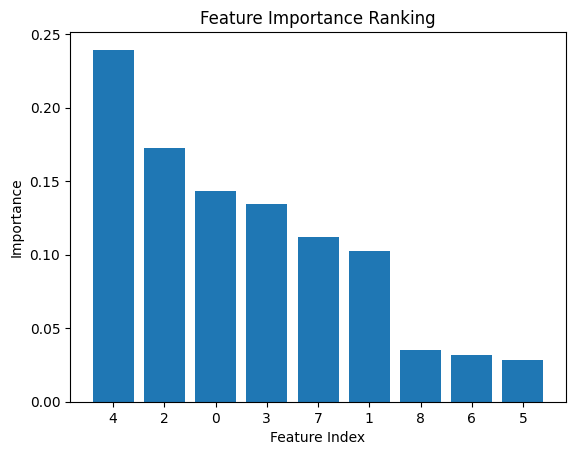

In [93]:
# Applied best parameters for the model to rank features
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

# Get feature importances from the trained model
importances = clf.feature_importances_

# Sort features based on importance
sorted_indices = importances.argsort()[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {sorted_indices[f]} ({importances[sorted_indices[f]]})")

# Plot the feature importances
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), sorted_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance Ranking")
plt.show()

In [79]:
X_df = ranking_df.drop('Target', axis = 1)
X_df.columns[[4, 2, 0, 3, 7, 1, 8, 6, 5]]

Index(['volume', 'low', 'open', 'close', 'Month', 'high', 'Year', 'Day',
       'Name'],
      dtype='object')

- Using DecisionTree as a base model for ranking the features.
- All the features that have an importance below 0.1 can be dropped.

#### New dataframe

In [99]:
comp_df.drop(['high', 'Year', 'Day', 'Name', 'date'], axis = 1, inplace = True)
comp_df

<ipython-input-99-82209504e19a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.drop(['high', 'Year', 'Day', 'Name', 'date'], axis = 1, inplace = True)


,open,low,close,volume,Target,Month
1259,67.7142,66.8928,67.8542,158168416,1,2
1260,68.0714,67.6071,68.5614,129029425,0,2
1261,68.5014,66.8205,66.8428,151829363,0,2
1262,66.7442,66.1742,66.7156,118721995,0,2
1263,66.3599,66.2885,66.6556,88809154,0,2
...,...,...,...,...,...,...
397747,43.0400,42.1000,42.4900,35713522,0,2
397748,42.0000,40.6100,40.8200,40657381,0,2
397749,40.1400,39.0100,39.4000,45796837,1,2
397750,40.5500,40.5500,43.8800,66972802,0,2


In [100]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12590 entries, 1259 to 397751
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    12590 non-null  float64
 1   low     12590 non-null  float64
 2   close   12590 non-null  float64
 3   volume  12590 non-null  int64  
 4   Target  12590 non-null  int64  
 5   Month   12590 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 688.5 KB


#### Target Distribution

1    6454
0    6136
Name: Target, dtype: int64

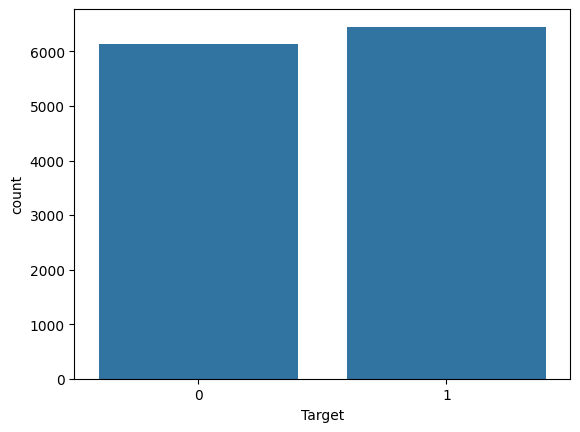

In [101]:
target = comp_df['Target'].value_counts()
sns.countplot(x ='Target',  data = comp_df)
target

- Target is balance

#### Bulding model

In [102]:
y = comp_df['Target']
X = comp_df.drop('Target', axis = 1)

# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [103]:
X[0]

array([ 0.72294433,  0.71698745,  0.72619076,  3.59144958, -1.32883359])

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8813, 5), (3777, 5), (8813,), (3777,))

In [130]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:31<00:00,  1.07s/it]

[LightGBM] [Info] Number of positive: 4487, number of negative: 4326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 8813, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509134 -> initscore=0.036541
[LightGBM] [Info] Start training from score 0.036541


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.52,0.52,0.52,0.52,0.03
XGBClassifier,0.52,0.52,0.52,0.52,0.22
Perceptron,0.51,0.51,0.51,0.50,0.04
KNeighborsClassifier,0.51,0.51,0.51,0.51,0.37
NearestCentroid,0.51,0.51,0.51,0.51,0.03
LabelPropagation,0.51,0.51,0.51,0.51,3.20
LabelSpreading,0.51,0.51,0.51,0.51,5.95
CalibratedClassifierCV,0.51,0.51,0.51,0.50,1.76
ExtraTreeClassifier,0.51,0.50,0.50,0.51,0.03


- PassiveAggressiveClassifier and XGBClassifier are the best models.
